In [16]:
import librosa
from glob import glob
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wav_files = sorted(glob('./data/background/YD/*.wav'))

In [170]:
# print(wav_files)

In [6]:
librosa.core.get_duration(filename=wav_files[0])

88.0

In [11]:
class MultiStreamLoader():
    
    def __init__(self, files, fs=22050):
        self.files = files
        self.fs = fs
        self.current_tracks = self.files.copy()
        random.shuffle(self.current_tracks)
        self.buffer_length = int(fs * 0.1)
        self.stream = librosa.core.stream(self.current_tracks[0], 1,
                                          self.buffer_length, self.buffer_length)
        
    def _update_stream(self):
        self.current_tracks.pop(0)
        
        if len(self.current_tracks) == 0:
            self.current_tracks = self.files.copy()
            random.shuffle(self.current_tracks)
        
        self.stream = librosa.core.stream(self.current_tracks[0], 1,
                                          self.buffer_length, self.buffer_length)
        
    def _get_stream(self):
        try:
            return next(self.stream)
        except StopIteration:
            self._update_stream()
            return next(self.stream)
        
    def get(self, sec):
        buffer = self._get_stream()
        while len(buffer) < sec * self.fs:
            buffer = np.concatenate((buffer, self._get_stream()), axis=0)
        return buffer

In [12]:
# librosa.core.stream(mp3_files[0], block_length, frame_length, hop_length)
# #                     dtype=<class 'numpy.float32'>)

In [13]:
background_stream_loader = MultiStreamLoader(wav_files)

In [47]:
'''
Pre-processing. 
The original raw waveforms were first downsampled from 48kHz to 16kHz.
For the actual model input, complex-valued spectrograms were obtained 
from the downsampled waveforms via STFT with a 64ms sized Hann window and 16ms hop length.
'''
print(16000 * 64 / 1000)
print(16000 * 16 / 1000)
print()

print(22050 * 64 / 1000)
print(22050 * 16 / 1000)
print()

print(352 / 22050 * 1000)
print(1412 / 22050 * 1000)
print()

print(512 / 22050 * 1000)
print(2048 / 22050 * 1000)
print()

1024.0
256.0

1411.2
352.8

15.96371882086168
64.03628117913831

23.219954648526077
92.87981859410431



In [48]:
for i in range(1):

    x = background_stream_loader.get(10)
#     print(background_stream_loader.current_tracks[0])
#     print(len(x))

In [51]:
speech_files = sorted(glob('./data/speech/KSS/*/*.wav'))

In [59]:
speech_file_lengths = [(f, librosa.core.get_duration(filename=f)) for f in speech_files]

In [67]:
l = [s[1] for s in speech_file_lengths]

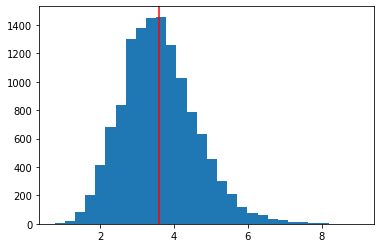

In [74]:
plt.figure()
plt.hist(l, bins=30) 
plt.axvline(x=np.mean(l), c='r')
plt.show()

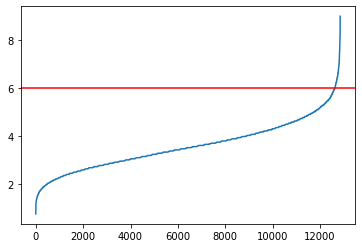

In [100]:
plt.figure()
plt.plot(sorted(l))
plt.axhline(y=6.0, c='r')
plt.show()

In [146]:
mu_graph = list()
sig_graph = list()

for i in np.arange(5, 7, 0.05):

#     plt.figure()
    l_array = np.array(sorted(l))
    summing_array = l_array[l_array <= i]
    left_array = l_array[l_array > i]
    sum_array = summing_array + np.flip(summing_array)
    result = np.concatenate([sum_array, left_array])
#     plt.plot(result)
#     plt.show()
    
    mu = np.mean(result)
    sig = np.std(result)
    
#     print(mu)
#     print(sig)
    
    mu_graph.append(i)
    sig_graph.append(sig)
    
#     plt.figure()
#     plt.hist(result, bins=30) 
#     plt.axvline(x=mu, c='r')
#     plt.show()
    

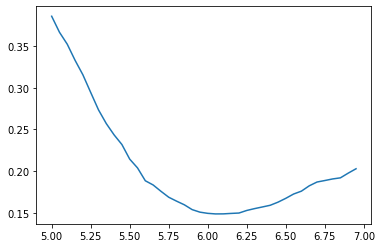

21
6.049999999999996


In [147]:
plt.figure()
plt.plot(mu_graph, sig_graph)
plt.show()

idx = np.argmin(sig_graph)
print(idx)
print(mu_graph[idx])

In [149]:
speech_file_lengths.sort(key=lambda x: x[1])

In [168]:
idx = np.argmin([abs(l[1] - 6.05) for l in speech_file_lengths])
if idx % 2 != 1:
    idx +=1 
    
folding_files = speech_file_lengths[:idx]
left_files = speech_file_lengths[idx:]

def fold(input_list):
    center = int((len(input_list) - 1) / 2)
    x = input_list[:center]
    y = input_list[center:][::-1]
    
    return [((a[0], b[0]), (a[1], b[1])) for a, b in zip(x, y)]

folded_files = fold(folding_files)

merge_files = folded_files + left_files

In [169]:
len(merge_files)

6531